In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import Birch
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

## Kidney Stone Dataset

In [2]:
df = pd.read_csv('/content/kidney-stone-dataset.csv')

In [3]:
df.head()

,Unnamed: 0,gravity,ph,osmo,cond,urea,calc,target
0,0,1.021,4.91,725,14.0,443,2.45,0
1,1,1.017,5.74,577,20.0,296,4.49,0
2,2,1.008,7.20,321,14.9,101,2.36,0
3,3,1.011,5.51,408,12.6,224,2.15,0
4,4,1.005,6.52,187,7.5,91,1.16,0


In [4]:
df.shape

(90, 8)

In [5]:
df.drop(['Unnamed: 0', 'target'], axis=1, inplace=True)

In [6]:
X = df

In [7]:
# Parámetros para la búsqueda en grilla (Grid Search)
param_grid = {
    'threshold': np.arange(0.1, 1, 0.1), # rango e incremento
    'branching_factor': np.arange(20, 100, 5),
    'n_clusters': np.arange(2, 10, 1) #empezar en 2 o no funciona
}

In [8]:
# Métrica de evaluación para la búsqueda en grilla
scoring = 'silhouette'

In [9]:
# Realizar la búsqueda en grilla
best_score = -np.inf
best_params = None

# Escalar características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Grid Search

In [11]:
# Realizar Grid-Search, 3 bucles for
for threshold in param_grid['threshold']:
    for branching_factor in param_grid['branching_factor']:
        for n_clusters in param_grid['n_clusters']:
            model = Birch(threshold=threshold, branching_factor=branching_factor, n_clusters=n_clusters)
            model.fit(X_scaled)
            labels = model.predict(X_scaled)
            score = silhouette_score(X_scaled, labels)
            if score > best_score:
                best_score = score
                best_params = {'threshold': threshold, 'branching_factor': branching_factor, 'n_clusters': n_clusters}

print(f"Mejores parámetros: {best_params}")
print(f"Mejor puntuación (silhouette): {best_score}")

Mejores parámetros: {'threshold': 0.8, 'branching_factor': 30, 'n_clusters': 2}
Mejor puntuación (silhouette): 0.3725227294444121


## Modelo

In [12]:
# Ajustar el modelo usando los mejores parámetros
best_model = Birch(**best_params)
best_model.fit(X_scaled)

Birch(branching_factor=30, n_clusters=2, threshold=0.8)

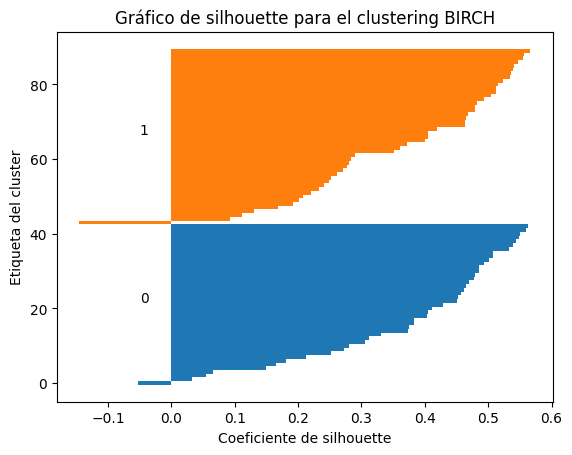

In [14]:
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

# Calcular coeficientes de silhouette para cada punto de datos
silhouette_vals = silhouette_samples(X_scaled, best_model.labels_)

# Graficar el gráfico de silhouette
y_lower, y_upper = 0, 0
for i in range(best_model.n_clusters):
    cluster_silhouette_vals = silhouette_vals[best_model.labels_ == i]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, height=1)
    plt.text(-0.05, (y_lower + y_upper) / 2, str(i))
    y_lower += len(cluster_silhouette_vals)

plt.xlabel("Coeficiente de silhouette")
plt.ylabel("Etiqueta del cluster")
plt.title("Gráfico de silhouette para el clustering BIRCH")
plt.show()

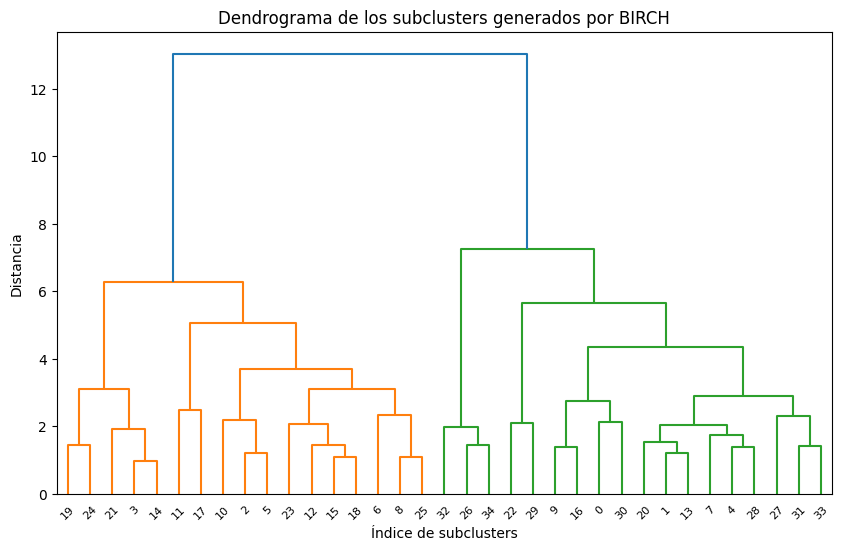

In [15]:
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage

# Función para obtener el número de puntos en un subcluster dado
def get_count(node):
    if node is None:
        return 0
    if node.left is None and node.right is None:
        return int(node.cf[0])
    else:
        return get_count(node.left) + get_count(node.right)


# Calcular el número de puntos en cada subcluster
subcluster_sizes = np.bincount(best_model.labels_)

# Calcular las distancias entre los centroides de los subclusters finales de BIRCH
subclusters = best_model.subcluster_centers_
Z = linkage(subclusters, method='ward')

# Función para etiquetar las ramas del dendrograma
def label_dendrogram(P):
    centroid = subclusters[P]
    return f"Centroid: ({centroid[0]:.2f}, {centroid[1]:.2f})"

# Visualizar el dendrograma
plt.figure(figsize=(10, 6))
dendrogram(Z)
plt.title("Dendrograma de los subclusters generados por BIRCH")
plt.xlabel("Índice de subclusters")
plt.ylabel("Distancia")
plt.show()

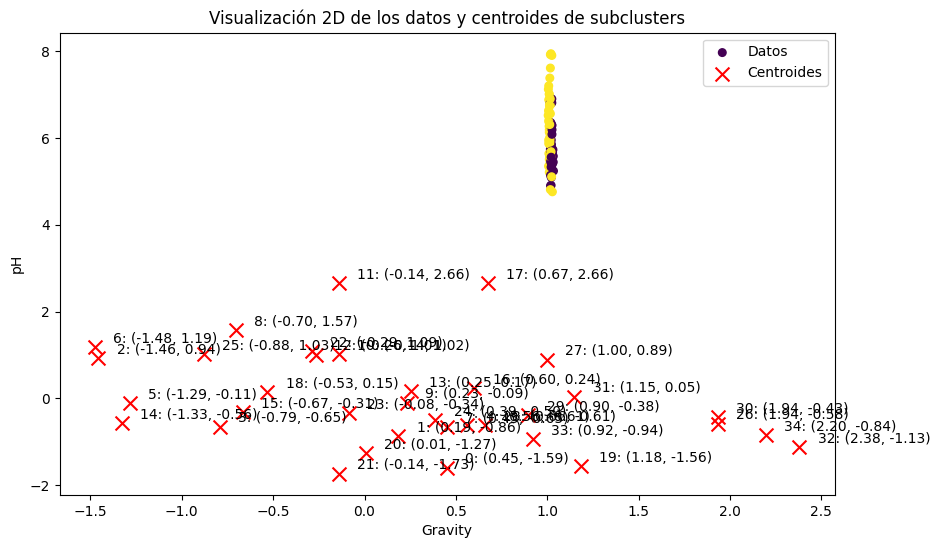

In [16]:
# Visualizar los datos y los centroides de los subclusters, mostrar gravity en el eje horizontal y pH en el vertical
plt.figure(figsize=(10, 6))
plt.scatter(X['gravity'], X['ph'], c=best_model.labels_, cmap='viridis', marker='o', s=30, label='Datos')
plt.scatter(subclusters[:, 0], subclusters[:, 1], c='red', marker='x', s=100, label='Centroides')


# Etiquetar los centroides
for i, centroid in enumerate(subclusters):
    plt.text(centroid[0] + 0.1, centroid[1] + 0.1, f"{i}: ({centroid[0]:.2f}, {centroid[1]:.2f})", fontsize=10)

plt.title("Visualización 2D de los datos y centroides de subclusters")
plt.xlabel("Gravity")
plt.ylabel("pH")
plt.legend()
plt.show()

## Clusters

In [17]:
cl=pd.DataFrame(best_model.labels_,columns=['Cluster'])

In [18]:
cl.value_counts()

Cluster
1          47
0          43
Name: count, dtype: int64

In [19]:
# Concatenar
df_final = pd.concat([df, cl], axis=1)

In [20]:
df_final.head()

,gravity,ph,osmo,cond,urea,calc,Cluster
0,1.021,4.91,725,14.0,443,2.45,0
1,1.017,5.74,577,20.0,296,4.49,0
2,1.008,7.20,321,14.9,101,2.36,1
3,1.011,5.51,408,12.6,224,2.15,1
4,1.005,6.52,187,7.5,91,1.16,1


## Interpretación

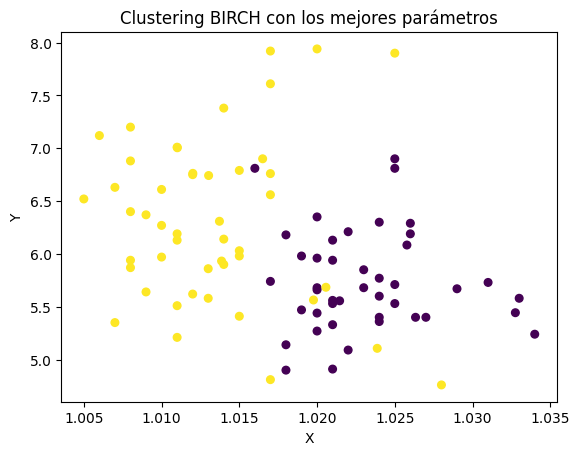

In [21]:
# Visualizar los resultados, un scatter de las dos primeras características
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=best_model.labels_, cmap='viridis', marker='o', s=30)
plt.title("Clustering BIRCH con los mejores parámetros")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [22]:
# Representación 3D x gravity, y ph y z osmo

import plotly.express as px
import plotly
fig = px.scatter_3d(df_final, x='gravity', y='ph', z='osmo', color='Cluster', title="Kidney Stone Analysis")
fig.show()

## Utilizamos K-means para clusterizar todos los datos a través de los subclusters propuestos por BIRCH.

## Comrpobamos que en efecto lo óptimo son 2 clusters

For 2 clusters: average silhouette_score is 0.3002965516128565
For 3 clusters: average silhouette_score is 0.2605460971306413
For 4 clusters: average silhouette_score is 0.2121625032137395
For 5 clusters: average silhouette_score is 0.22691545227680576
For 6 clusters: average silhouette_score is 0.2609120855299625
For 7 clusters: average silhouette_score is 0.22143633721803782
For 8 clusters: average silhouette_score is 0.21156616968133776


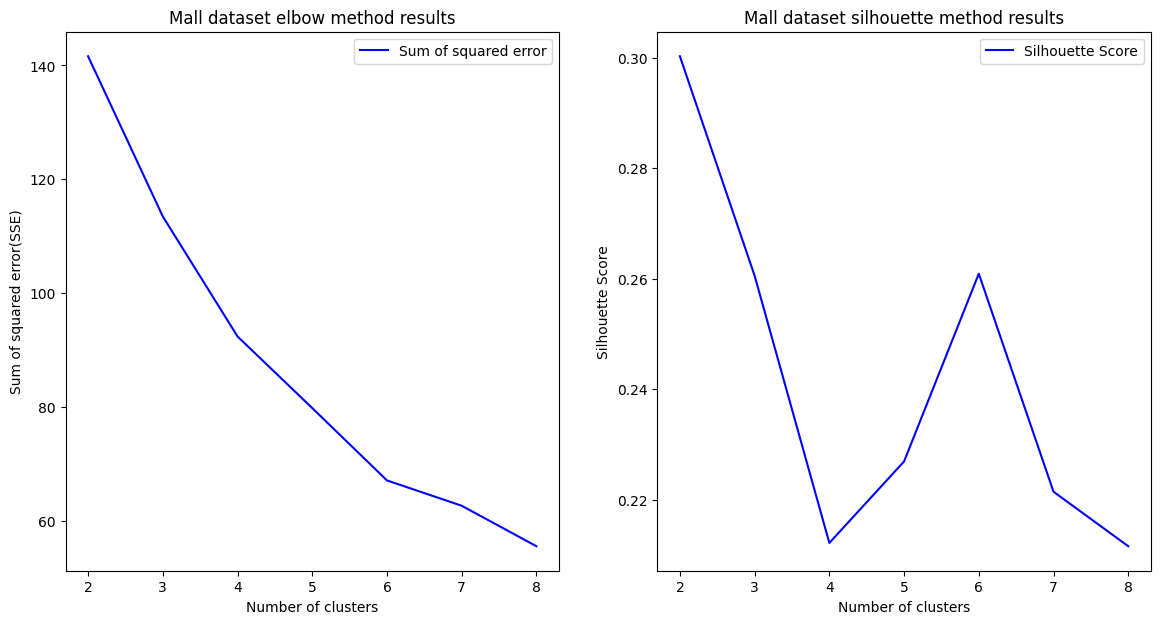

In [23]:
from sklearn.cluster import KMeans
range_n_clusters = range(2, 9)
elbow = []
ss = []
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
    cluster_labels = clusterer.fit_predict(subclusters)
    silhouette_avg = silhouette_score(subclusters, cluster_labels)
    ss.append(silhouette_avg)
    print(f"For {n_clusters} clusters: average silhouette_score is {silhouette_avg}")
    elbow.append(clusterer.inertia_) # Inertia: Sum of distances of samples to their closest cluster center

fig = plt.figure(figsize=(14,7))

fig.add_subplot(121)
plt.title("Mall dataset elbow method results")
plt.plot(range_n_clusters, elbow,'b-',label='Sum of squared error')
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squared error(SSE)")
plt.legend()

fig.add_subplot(122)
plt.title("Mall dataset silhouette method results")
plt.plot(range_n_clusters, ss,'b-',label='Silhouette Score')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()

## Utilizamos los subclusters de BIRCH como entrenamiento de K-means

In [24]:
# Calcular los centroides de los subclusters
subcluster_centers = best_model.subcluster_centers_

In [25]:
from sklearn.cluster import KMeans
# Aplicar K-Means a los centroides de los subclusters
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(subcluster_centers)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KMeans(n_clusters=2, random_state=42)

## Predecimos todos los puntos

In [26]:
# Asignar las etiquetas de K-Means a los puntos de datos originales
final_labels = kmeans.predict(X_scaled)

In [27]:
final_labels

array([0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1], dtype=int32)

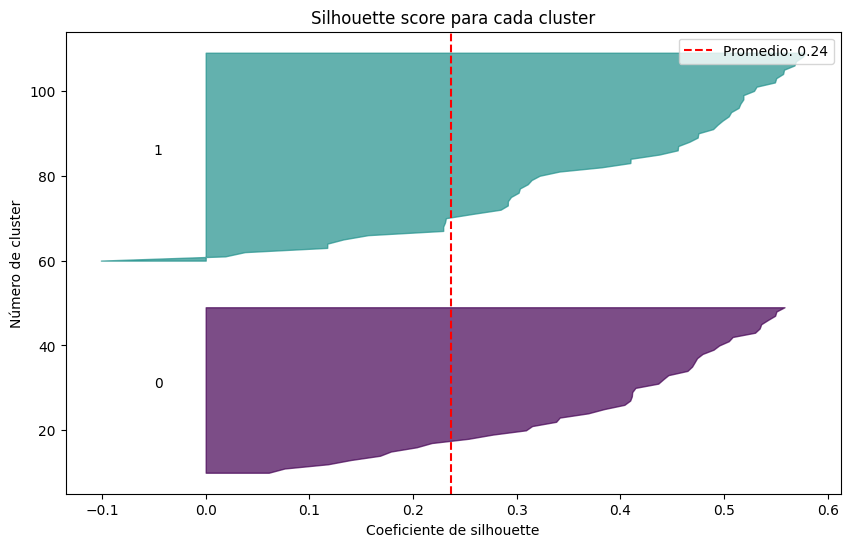

In [28]:
# Calcular los silhouette scores de cada punto de datos
silhouette_values = silhouette_samples(X_scaled, final_labels)

# Calcular y mostrar el silhouette score promedio para cada cluster
fig, ax = plt.subplots(figsize=(10, 6))
y_lower = 10

unique_clusters = np.unique(final_labels)

for i in unique_clusters:
    # Filtrar los silhouette scores del cluster actual
    cluster_silhouette_values = silhouette_values[final_labels == i]

    # Ordenar y calcular el tamaño del cluster
    cluster_silhouette_values.sort()
    size_cluster_i = cluster_silhouette_values.shape[0]

    # Visualizar el silhouette score para cada punto en el cluster
    y_upper = y_lower + size_cluster_i
    color = plt.cm.viridis(float(i) / len(unique_clusters))
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

    # Etiquetar el gráfico con el número del cluster
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Calcular la posición del siguiente cluster
    y_lower = y_upper + 10

ax.set_title("Silhouette score para cada cluster")
ax.set_xlabel("Coeficiente de silhouette")
ax.set_ylabel("Número de cluster")
ax.axvline(x=score, color="red", linestyle="--", label=f"Promedio: {score:.2f}")
ax.legend()
plt.show()

In [29]:
from sklearn.metrics import silhouette_score

# Calcular el silhouette score usando las etiquetas finales y los datos originales
score = silhouette_score(X_scaled, final_labels)

print(f"Silhouette score: {score:.3f}")

Silhouette score: 0.379


## Hemos mejorado de 0.372 a 0.379, en este caso no es mucho pero según los datos podemos obetner diferencias significativas.

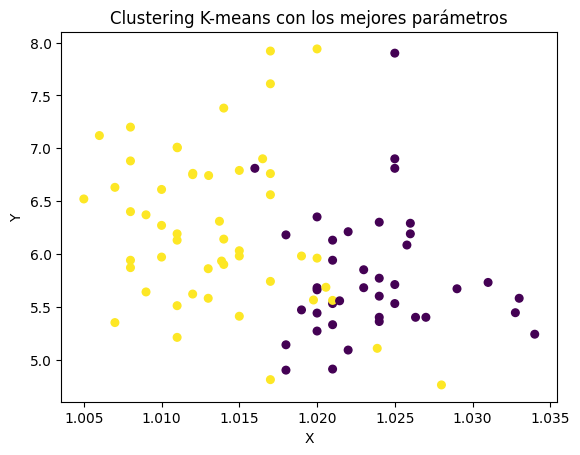

In [30]:
# Visualizar los resultados
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=final_labels, cmap='viridis', marker='o', s=30)
plt.title("Clustering K-means con los mejores parámetros")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [31]:
cl_kmeans=pd.DataFrame(final_labels,columns=['Cluster_kmeans'])

In [32]:
cl_kmeans.value_counts()

Cluster_kmeans
1                 50
0                 40
Name: count, dtype: int64

In [33]:
df_kmeans = pd.concat([df,cl_kmeans],axis=1)

In [34]:
df_kmeans.head()

,gravity,ph,osmo,cond,urea,calc,Cluster_kmeans
0,1.021,4.91,725,14.0,443,2.45,0
1,1.017,5.74,577,20.0,296,4.49,1
2,1.008,7.20,321,14.9,101,2.36,1
3,1.011,5.51,408,12.6,224,2.15,1
4,1.005,6.52,187,7.5,91,1.16,1


In [35]:
import plotly.express as px
import plotly
fig = px.scatter_3d(df_kmeans, x='gravity', y='ph', z='osmo', color='Cluster_kmeans',title="Kidney Stone Analysis")
fig.show()

In [36]:
fig = px.scatter_3d(df_kmeans, x='gravity', y='cond', z='urea', color='Cluster_kmeans',title="Kidney Stone Analysis")
fig.show()

## Vamos a comparar BIRCH + K-means vs DBSCAN

## DBSCAN

In [37]:
from sklearn.cluster import DBSCAN

In [38]:
X2 = df

In [39]:
from sklearn.neighbors import NearestNeighbors
# Encontrar las distancias k
k = 6
# Obtenemos las distancias
nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

In [40]:
# Ordenar las distancias
distances_mean = np.mean(distances[:, 1:], axis=1)
distances_mean = np.sort(distances_mean)

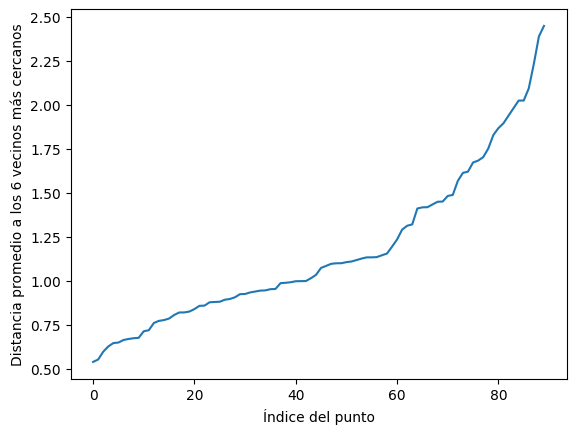

In [41]:
# Graficar las distancias k
plt.plot(distances_mean)
plt.xlabel('Índice del punto')
plt.ylabel(f'Distancia promedio a los {k} vecinos más cercanos')
plt.show()

In [42]:
# Definir el espacio de búsqueda para eps y min_samples
eps_values = np.arange(0.5, 2.5, 0.1) # rango e incremento
min_samples_values = np.arange(2, 10, 1) # rango e incremento

# Realizar la búsqueda en malla (grid search)
best_score = -1
best_params = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(X_scaled)

        # Ignorar resultados con solo un cluster o clusters asignados como ruido
        if len(np.unique(clusters)) > 1 and np.any(clusters == -1):
            score = silhouette_score(X_scaled, clusters)
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}

# Imprimir los mejores valores de eps y min_samples
print(f"Mejores parámetros: {best_params}, Mejor coeficiente de silueta: {best_score}")

Mejores parámetros: {'eps': 1.8999999999999997, 'min_samples': 5}, Mejor coeficiente de silueta: 0.2864931371088952


In [43]:
# Aplicar DBSCAN con los mejores parámetros encontrados
dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
clusters = dbscan.fit_predict(X_scaled)

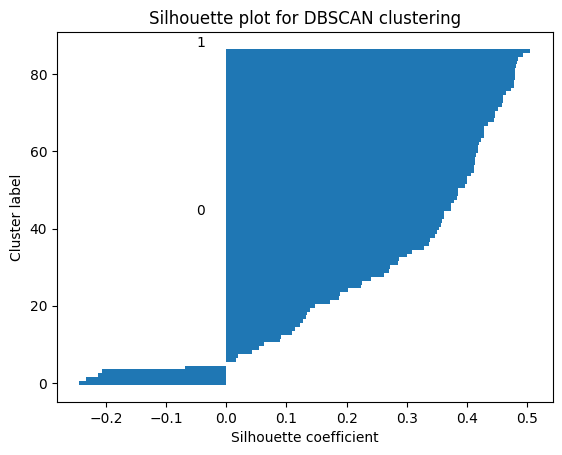

In [44]:
# Calculate silhouette coefficients for each data point
silhouette_vals2 = silhouette_samples(X_scaled, dbscan.labels_)

# Plot silhouette plot
y_lower, y_upper = 0, 0
for i in range(best_model.n_clusters):
    cluster_silhouette_vals = silhouette_vals2[dbscan.labels_ == i]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, height=1)
    plt.text(-0.05, (y_lower + y_upper) / 2, str(i))
    y_lower += len(cluster_silhouette_vals)

plt.xlabel("Silhouette coefficient")
plt.ylabel("Cluster label")
plt.title("Silhouette plot for DBSCAN clustering")
plt.show()

## Solo obtenemos un cluster, DBSCAN es muy sensible a outliers y es muy probable que tengamos varios outliers ensuciando el dataset.

In [45]:
cl2=pd.DataFrame(dbscan.labels_,columns=['Cluster'])

In [46]:
cl2.value_counts()

Cluster
 0         87
-1          3
Name: count, dtype: int64

In [47]:
df_final2 = pd.concat([df,cl2],axis=1)

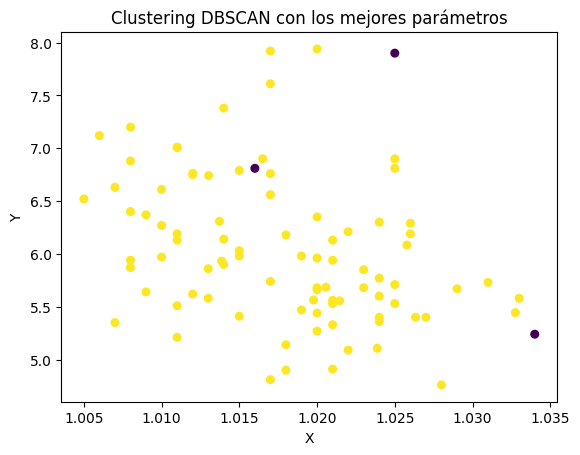

In [48]:
# Visualizar los resultados
labels = dbscan.labels_
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=labels, cmap='viridis', marker='o', s=30)
plt.title("Clustering DBSCAN con los mejores parámetros")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [49]:
import plotly.express as px
import plotly
fig = px.scatter_3d(df_final2, x='gravity', y='ph', z='osmo', color='Cluster',title="Kidney Stone Analysis")
fig.show()

In [50]:
fig = px.scatter_3d(df_final2, x='gravity', y='cond', z='urea', color='Cluster',title="Kidney Stone Analysis")
fig.show()